# Gradient-based Path Finding 

Let's consider once again the task of finding a shortest path within a maze. In this instance we are interested in exploiting a gradient-based approach that plays nicely with vectorization. Assume it is possible to move only along the four main directions.

The idea behind the algorithms is the following. It starts by initializing the value for the starting position to a given float value, for instance $1.0$. Every other traversable node is initially set to zero. The algorithm then iteratively updates the value of each cell by computing the maximum among its current value and the discounted value of all its neighbours. Such a discounted value is obtained by multiplying the current value of a neighbour by a given factor $\delta$, with $\delta < 1$. The procedure continues until the gradient reaches the target position, that in turn assumes a strictly positive value for the first time. The shortest path is identified by climbing the gradient, favouring the steepest ascent, from the end point.

In the image below, you can find a visual representation of a few steps of the algorithm in a small sample maze, considering $\delta$ equal to $0.9$.

<center><img src="grad_maze.png"/></center>

For this task, a set of sample mazes of various shapes is available (in the subfolder `./mazes`). All mazes are solvable. All mazes have a frame of walls along the first/last row/column.

As a sample result, the following image depicts the solution for maze number 4. Solid black cells are walls, solid white cells are unexplored areas, gradient-filled cells are nodes evaluated by the algorithm and white dots represent the path from start to exit.

<center><img src="solved_maze_4.png"/></center>

Your task is to implement the proposed algorithm using both pure iteration in Python and in a vectorized fashion relying on NumPy, and to compare their performance.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import glob
import random
from collections import deque
from matplotlib.colors import LogNorm

select a maze: - 0 - 1 - 2 - 3 - 4 
 4


GOAL!
non vectorized approach computational time: 0.022989511489868164
vectorized approach computational time: 0.03360128402709961


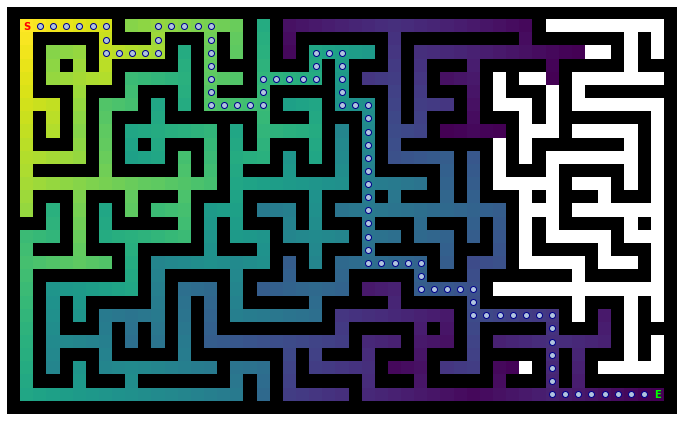

In [77]:
DELTA=.9

def reader():
    mazes_files=glob.glob('mazes'+'/*.npy')
    mazes=[]
    for maze_file in mazes_files:
        with open(maze_file, 'rb') as fp:
            mazes.append(np.load(fp))
    return mazes

def contour(maze,coords):
    contour = set()
    for j in (-1,0,1):
        for k in (-1,0,1):
            if not (j==k or j==-k):
                neigh_coords=(coords[0]+j,coords[1]+k)
                if not maze[neigh_coords[0],neigh_coords[1]]:
                    contour.add(neigh_coords)               
    return contour    
        
def gradient_computer(maze,gradient,coords):
    return max(gradient[coords[0],coords[1]] , DELTA*max([gradient[neigh[0],neigh[1]] for neigh in contour(maze,coords)]))

def algo(maze,gradient,start,stop):
    
    Q=deque()
    discovered=set()
    root=start
    discovered.add(root)
    Q.append(root)

    while Q:
        v=Q.popleft()
        gradient[v[0],v[1]]=gradient_computer(maze,gradient,v)
        if v==stop:
            print('GOAL!')
            return gradient
        for w in contour(maze,v)-discovered:
            discovered.add(w)
            Q.append(w)
            
def algo_vec(gradient,stop):
    while(gradient[stop]==0):
        padded = np.pad(gradient, pad_width=1, mode='edge')# Pad the image: add two rows and two columns
        center = padded[1:-1, 1:-1] # reference cell
        top = DELTA*padded[:-2, 1:-1] # previous row, same column                 
        bottom = DELTA*padded[2:, 1:-1] # next row, same column
        left = DELTA*padded[1:-1, :-2] # same row, previous column
        right = DELTA*padded[1:-1, 2:] # previous row, next column
        np.maximum(center,np.maximum(np.maximum(top,bottom),np.maximum(left,right)),where=center!=-1,out=gradient)
    return gradient

def steepest_ascent(maze, gradient, start, stop):
    root = stop
    path = [root]
    while root != start:
        neighbors_grads = {neigh: gradient[neigh[0], neigh[1]] for neigh in contour(maze,root)}
        root=max(neighbors_grads,key=neighbors_grads.get)
        path.append(root)
    return path

def plotter(gradient,path):
    path_matrix=np.zeros_like(gradient)
    for loc in path[1:-1]:
        path_matrix[loc]=1
    discovered = np.ma.masked_array(gradient, gradient <= 0)
    atlantis = np.ma.masked_array(gradient, gradient != 0)
    walls = np.ma.masked_array(gradient, gradient != -1) 
    fig,ax=plt.subplots(figsize=(12,12))
    ax.imshow(discovered,cmap='viridis',norm=LogNorm())
    for (j,i),dot in np.ndenumerate(path_matrix):
        if dot==1:
            ax.plot(i,j,'o',color='lightsteelblue',mec='darkblue')
    ax.text(path[-1][1],path[-1][0],'S',weight='black',color='red',ha='center',va='center')
    ax.text(path[0][1],path[0][0],'E',weight='black',color='lime',ha='center',va='center')
    ax.imshow(atlantis,cmap='binary')
    ax.imshow(walls,cmap='gray')
    plt.axis('off')
    #fig.savefig('C:/Users/piero/Documents/PHD/corsi/data_structures/M4/GradientPath')
                       
def main():
    
    mazes=reader()
    i=input("select a maze: - 0 - 1 - 2 - 3 - 4 \n")
    maze=mazes[int(i)]
    start=(1,1)
    stop=(len(maze)-2,len(maze[0])-2)
    gradient=-1.*maze
    gradient[start[0],start[1]]=1
    gradient_vec=gradient.copy()
    
    one=time.time()
    gradient=algo(maze,gradient,start,stop)
    two=time.time()
    print('non vectorized approach computational time: '+str(two-one))
    
    gradient_vec=algo_vec(gradient_vec,stop)
    print('vectorized approach computational time: '+str(time.time()-two))
    
    shortest_path=steepest_ascent(maze,gradient_vec,start,stop)
    plotter(gradient,shortest_path)
    
    pass

if __name__ == '__main__':
    main()   
    